In [4]:
from autoencodeSVJ.utils import data_loader, data_table
from autoencodeSVJ.models import base_autoencoder training_skeleton, autoencoder_skeleton
import autoencodeSVJ.models as models
import glob
import os
import numpy as np

### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [2]:
# get h5 datasets
samples = glob.glob("../data/dijet_loose/full.h5")

for sample in samples:
    loader = data_loader("main sample")
    loader.add_sample(sample)

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_loose/full.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']


Note that we normalize our training/testing each with respect to the full data sample. 

WE also need to stack the two jets into a single sample - we want jet-based analysis in this case.

In [3]:
data_event = loader.make_table()
j1table, j2table = data_event.split_by_column_names("j1*")

j1table = data_table(
    np.asarray(j1table.df),
    headers=list(map(lambda x: x.replace("j1", "jet"), j1table.headers)),
    name="jet1"
)

j2table = data_table(
    np.asarray(j2table.df),
    headers=list(map(lambda x: x.replace("j2", "jet"), j2table.headers)),
    name="jet2"
)

data = data_table(
    data=np.vstack([j1table.df, j2table.df]),
    headers=j1table.headers,
    name="full data"
)
train, test = data.train_test_split(0.4)
train_norm, test_norm = data.norm(train), data.norm(test)
print train_norm.shape, test_norm.shape

data_loader :: Grabbing dataset with keys [u'event_feature_data']
(444955, 7) (296637, 7)


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

data_table :: plotting distrubution(s) for table(s) ['full data', 'train', 'test']


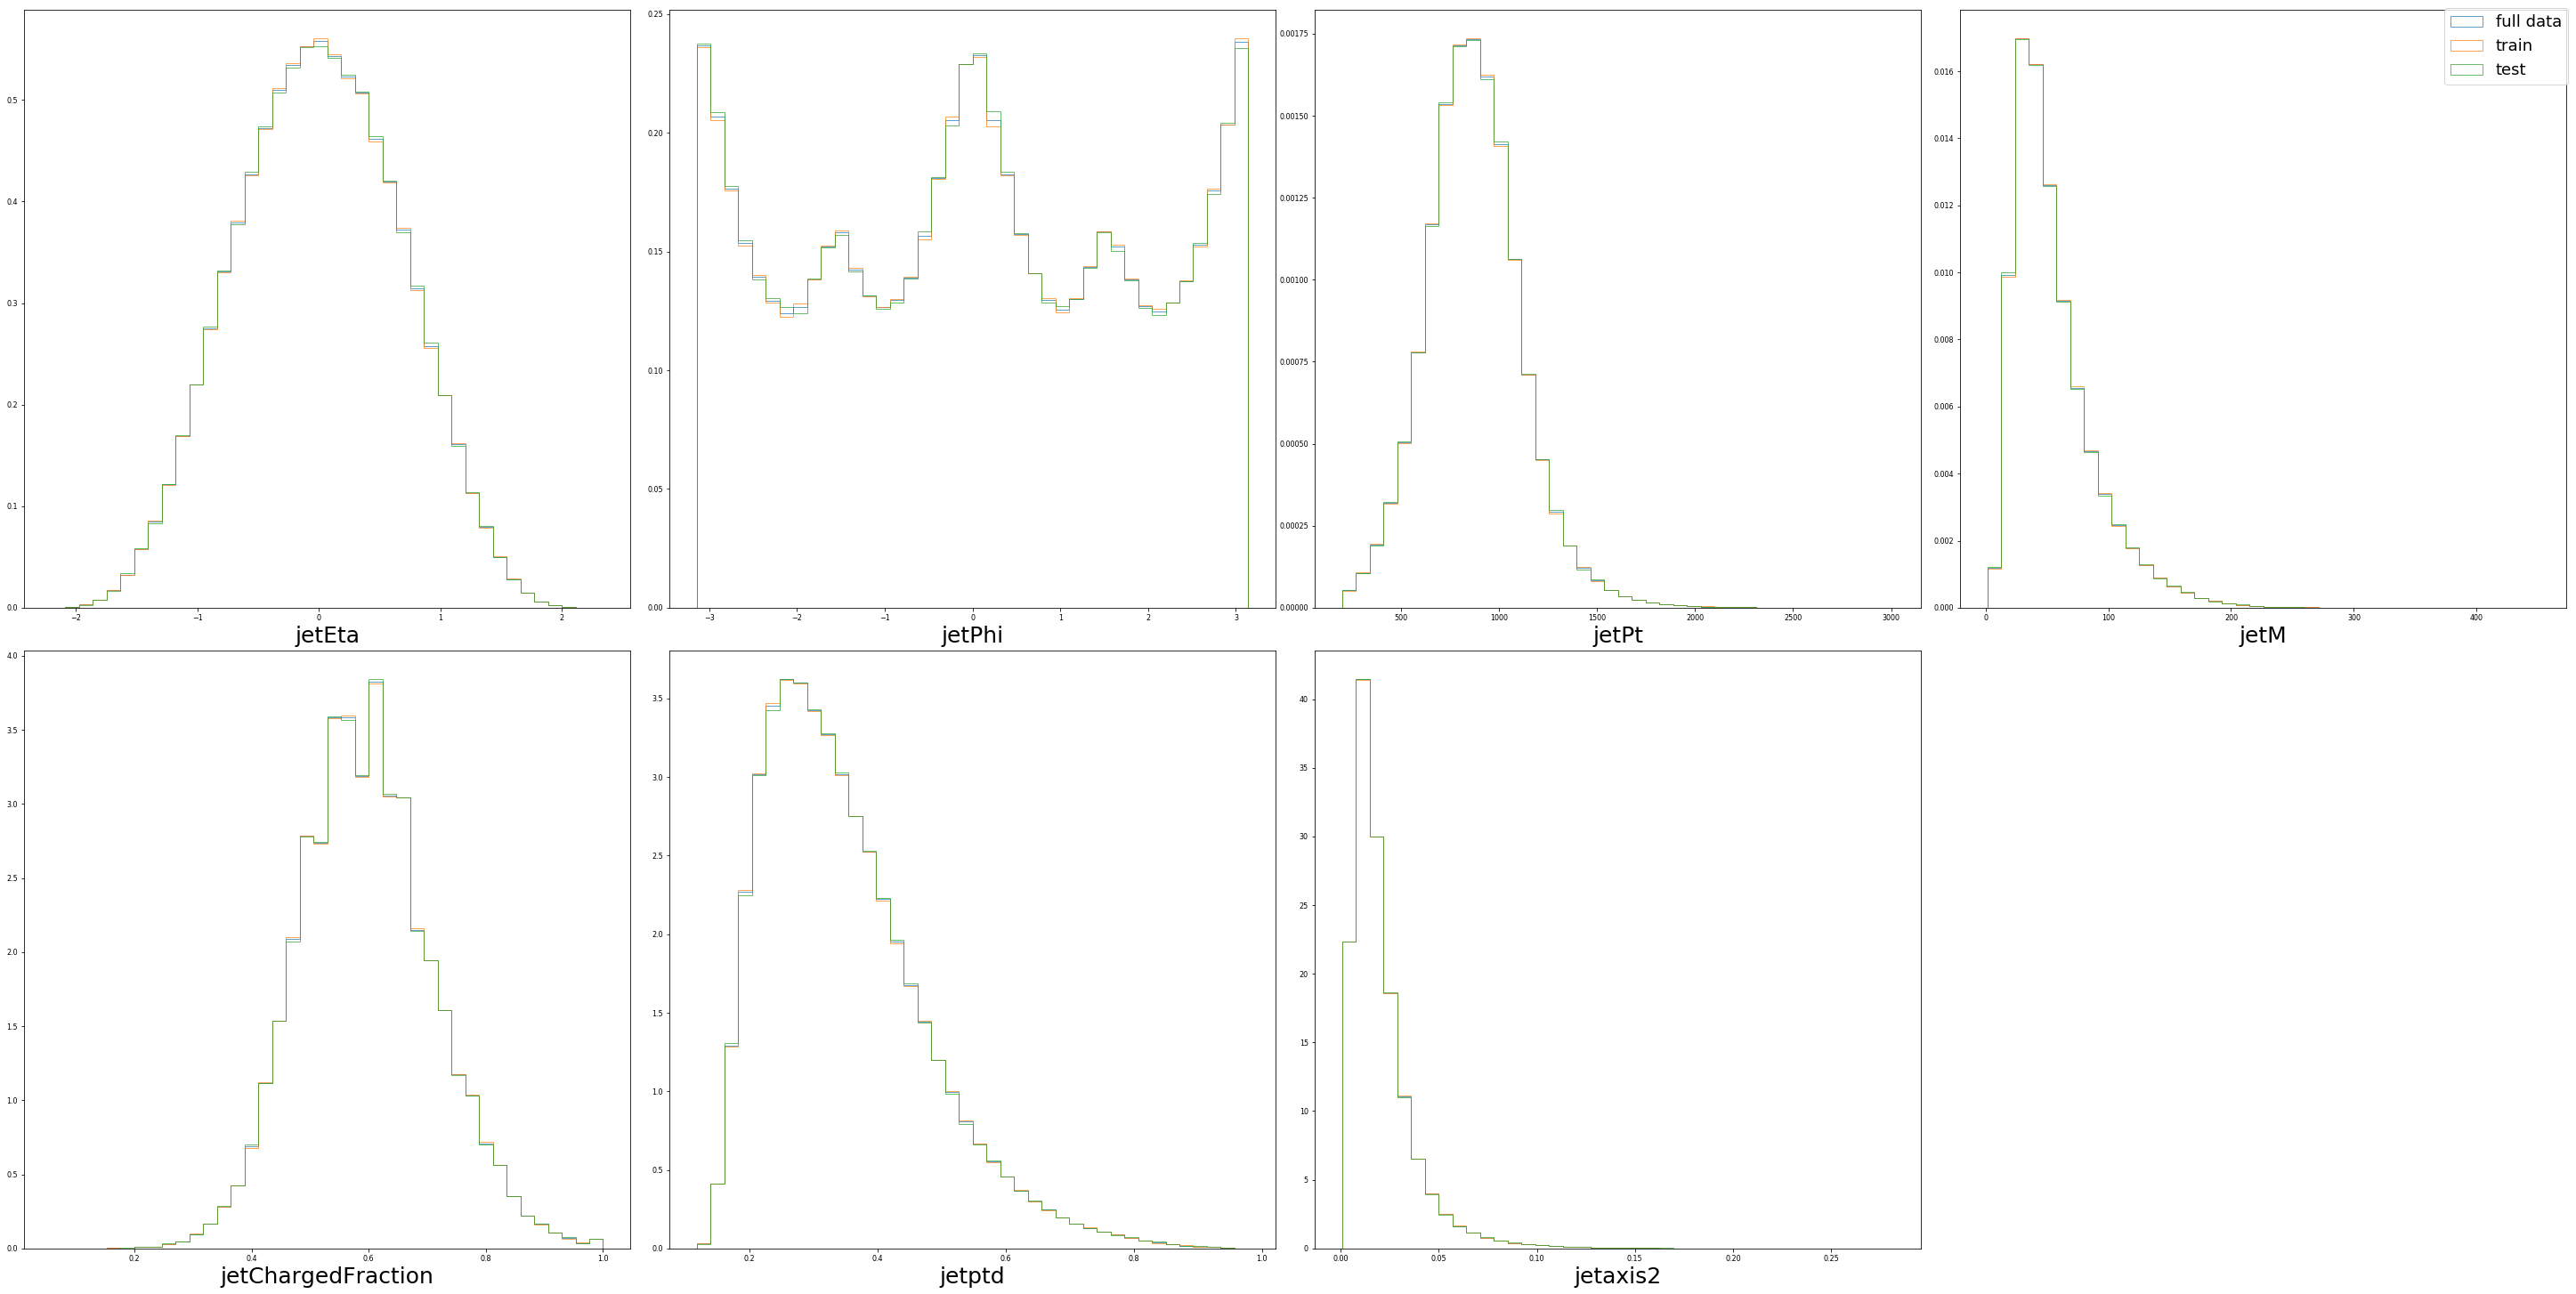

data_table :: plotting distrubution(s) for table(s) ['full data', 'jet1', 'jet2']


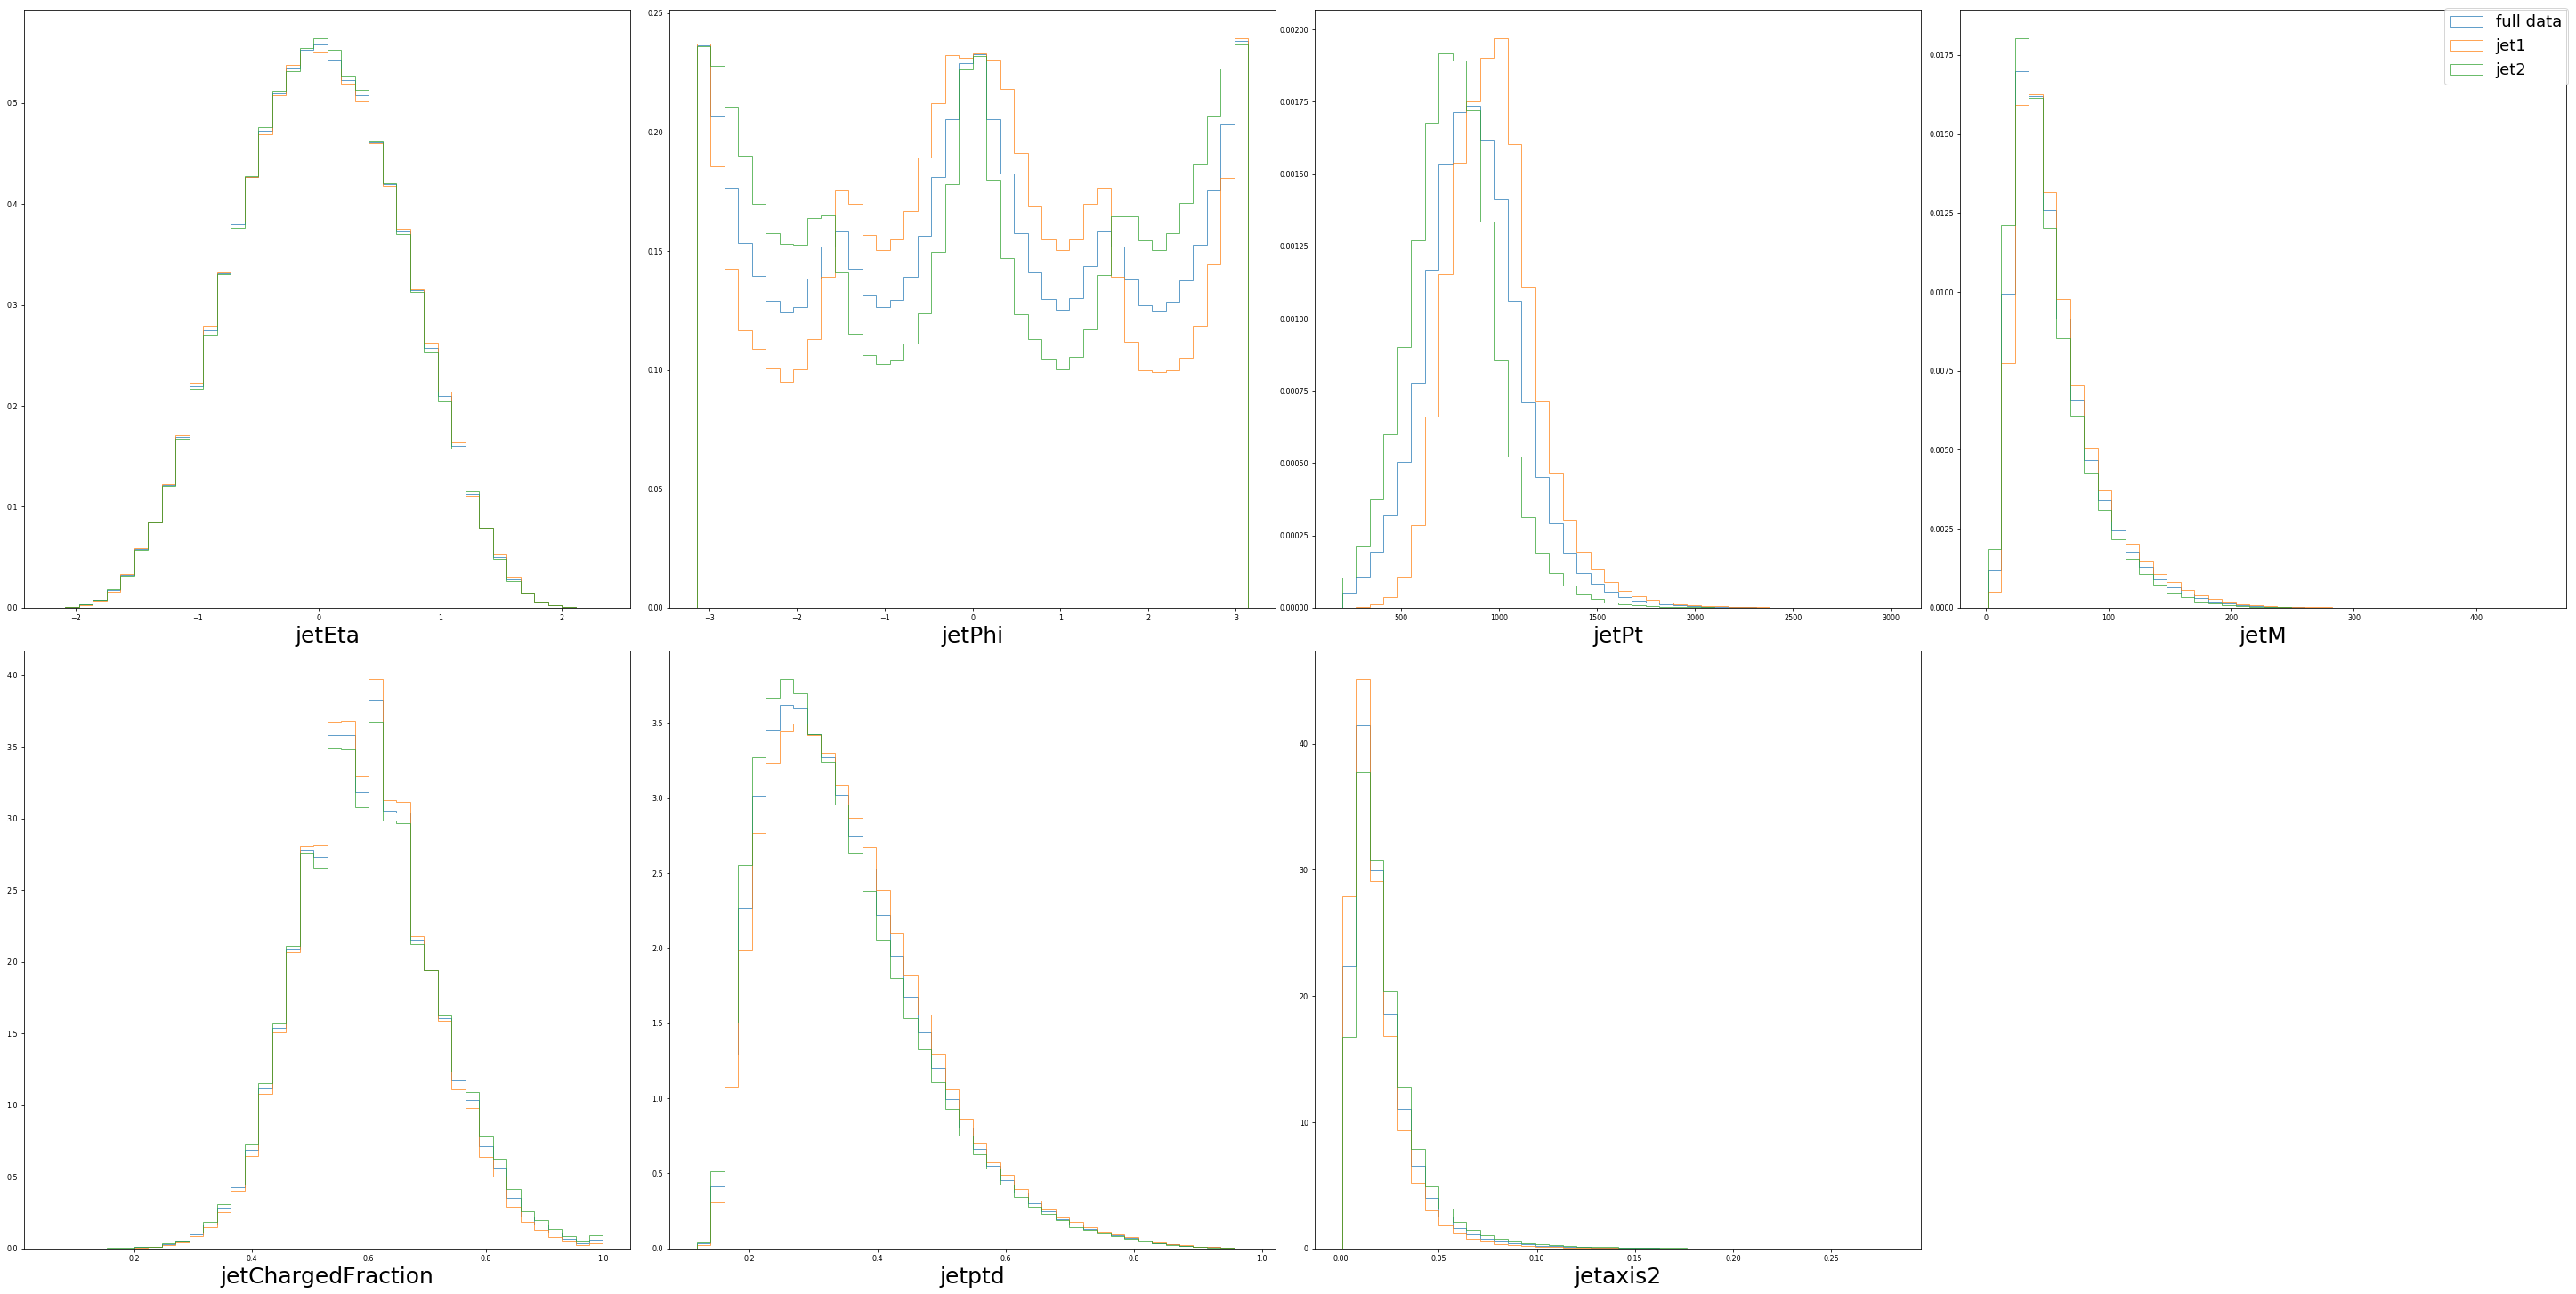

In [4]:
data.plot([train, test], normed=1, bins=40, figsize=(40,20), fontsize=25, cols=4)
data.plot([j1table, j2table], normed=1, bins=40, figsize=(40,20), fontsize=25, cols=4)

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [5]:
autoencoder = models.shallow(bn=4, n_features=data.shape[1])
encoder, decoder = autoencoder.layers[1:]

... and the model summaries:

In [6]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()


encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
layer_2 (Dense)              (None, 4)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


decoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
layer_3 (Dense)              (None, 7)                 35        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


autoencoder summary:
_________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [22]:
name = "shallow_4"
trainer = training_skeleton(os.path.join("data/training_runs/7jf", name))

train_shell :: locking file '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/7jf/shallow_4.h5'
h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'shallow_4.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'shallow_4.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'shallow_4.h5'
h5_elt 'val_r_square' :: loading dataset 'metric_names/val_r_square' from file 'shallow_4.h5'
h5_elt 'loss' :: loading dataset 'metric_names/loss' from file 'shallow_4.h5'
h5_elt 'mean_absolute_error' :: loading dataset 'metric_names/mean_absolute_error' from file 'shallow_4.h5'
h5_elt 'val_mean_absolute_error' :: loading dataset 'metric_names/val_mean_absolute_error' from file 'shallow_4.h5'
h5_elt 'r_square' :: loading dataset 'metric_names/r_square' from file 'shallow_4.h5'
h5_elt 'val_loss' :: loading dataset 'metric_names/val_loss' from file 'shallow_4.h5'


the `training_skeleton` object locks the file it works on while it trains, meaning you cannot have duplicates:

In [8]:
try:
    duplicate = training_skeleton(os.path.join("data/training_runs/7jf", name))
except AttributeError as e:
    print e

train_shell :: ERROR: filename '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/7jf/shallow_4.h5' is already being edited in another instance!!
filename '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/7jf/shallow_4.h5' is already being edited in another instance!!
train_shell :: unlocking file 'shallow_4.h5'


training is easy:

In [10]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

autoencoder = trainer.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss="mse",
    epochs=20,
    model=autoencoder,
    metrics=[r_square],
    force=False,
    batch_size=10000
)

train_shell :: TRAINING EPOCH 0/20
Train on 444955 samples, validate on 296637 samples
Epoch 1/1
44/44 [==============================] - 4s 92ms/step - loss: 0.1341 - r_square: -1.3787 - val_loss: 0.1103 - val_r_square: -0.9593
train_shell :: TRAINING EPOCH 1/20
Train on 444955 samples, validate on 296637 samples
Epoch 2/2
44/44 [==============================] - 3s 78ms/step - loss: 0.0961 - r_square: -0.7043 - val_loss: 0.0837 - val_r_square: -0.4859
train_shell :: TRAINING EPOCH 2/20
Train on 444955 samples, validate on 296637 samples
Epoch 3/3
44/44 [==============================] - 4s 81ms/step - loss: 0.0752 - r_square: -0.3342 - val_loss: 0.0673 - val_r_square: -0.1960
train_shell :: TRAINING EPOCH 3/20
Train on 444955 samples, validate on 296637 samples
Epoch 4/4
44/44 [==============================] - 4s 81ms/step - loss: 0.0614 - r_square: -0.0895 - val_loss: 0.0557 - val_r_square: 0.0103
train_shell :: TRAINING EPOCH 4/20
Train on 444955 samples, validate on 296637 sample

Training will also pick up where you left off, if at all possible - so make sure to delete unwanted models or change nomenclature when you want a new training session.

In [23]:
autoencoder = trainer.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    optimizer="adam",
    loss="mse",
    epochs=2,
    verbose=1,
    metrics=['mae'],
    batch_size=1000,
)

train_shell :: using saved model
train_shell :: TRAINING EPOCH 30/32
Train on 444955 samples, validate on 296637 samples
Epoch 31/31
444/444 [==============================] - 37s 82ms/step - loss: 0.0040 - mean_absolute_error: 0.0389 - val_loss: 0.0040 - val_mean_absolute_error: 0.0375
train_shell :: TRAINING EPOCH 31/32
Train on 444955 samples, validate on 296637 samples
Epoch 32/32
444/444 [==============================] - 37s 83ms/step - loss: 0.0040 - mean_absolute_error: 0.0374 - val_loss: 0.0040 - val_mean_absolute_error: 0.0374
train_shell :: 
train_shell :: trained 2 epochs!
train_shell :: 
train_shell :: model saved


### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

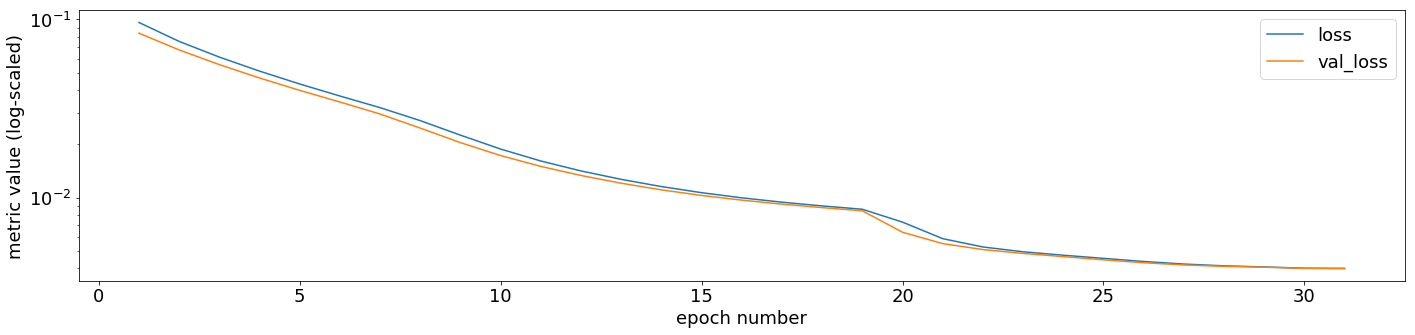

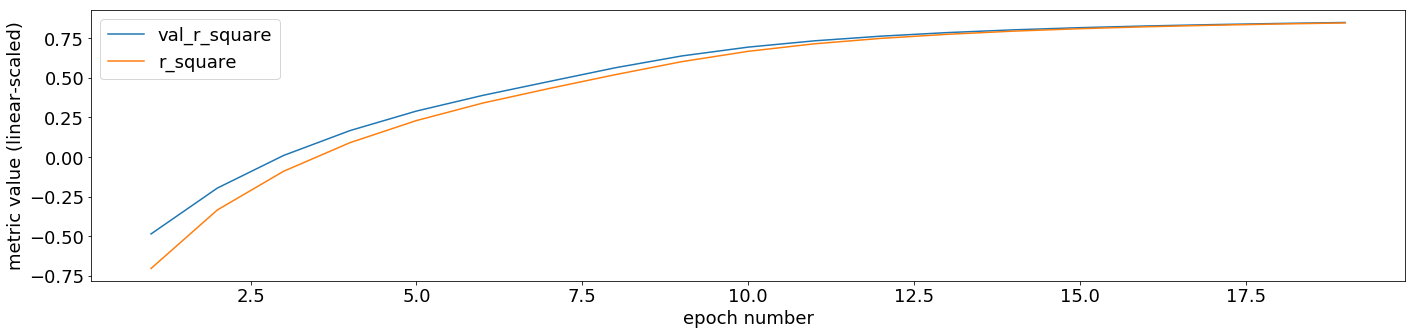

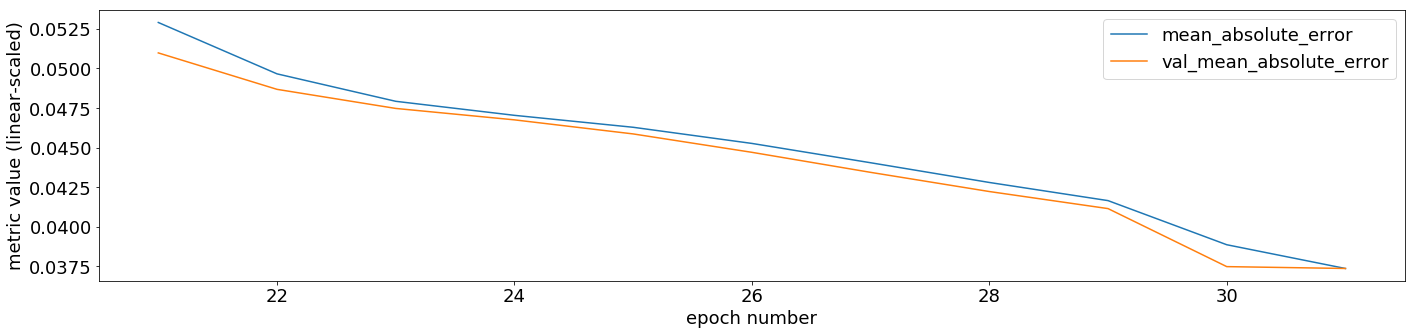

In [24]:
trainer.plot_metrics(fnmatch_criteria="*loss*", yscale="log")
trainer.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")
trainer.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")

checking results:

data_table :: plotting distrubution(s) for table(s) ['full data', 'train reconstructed', 'test reconstructed']


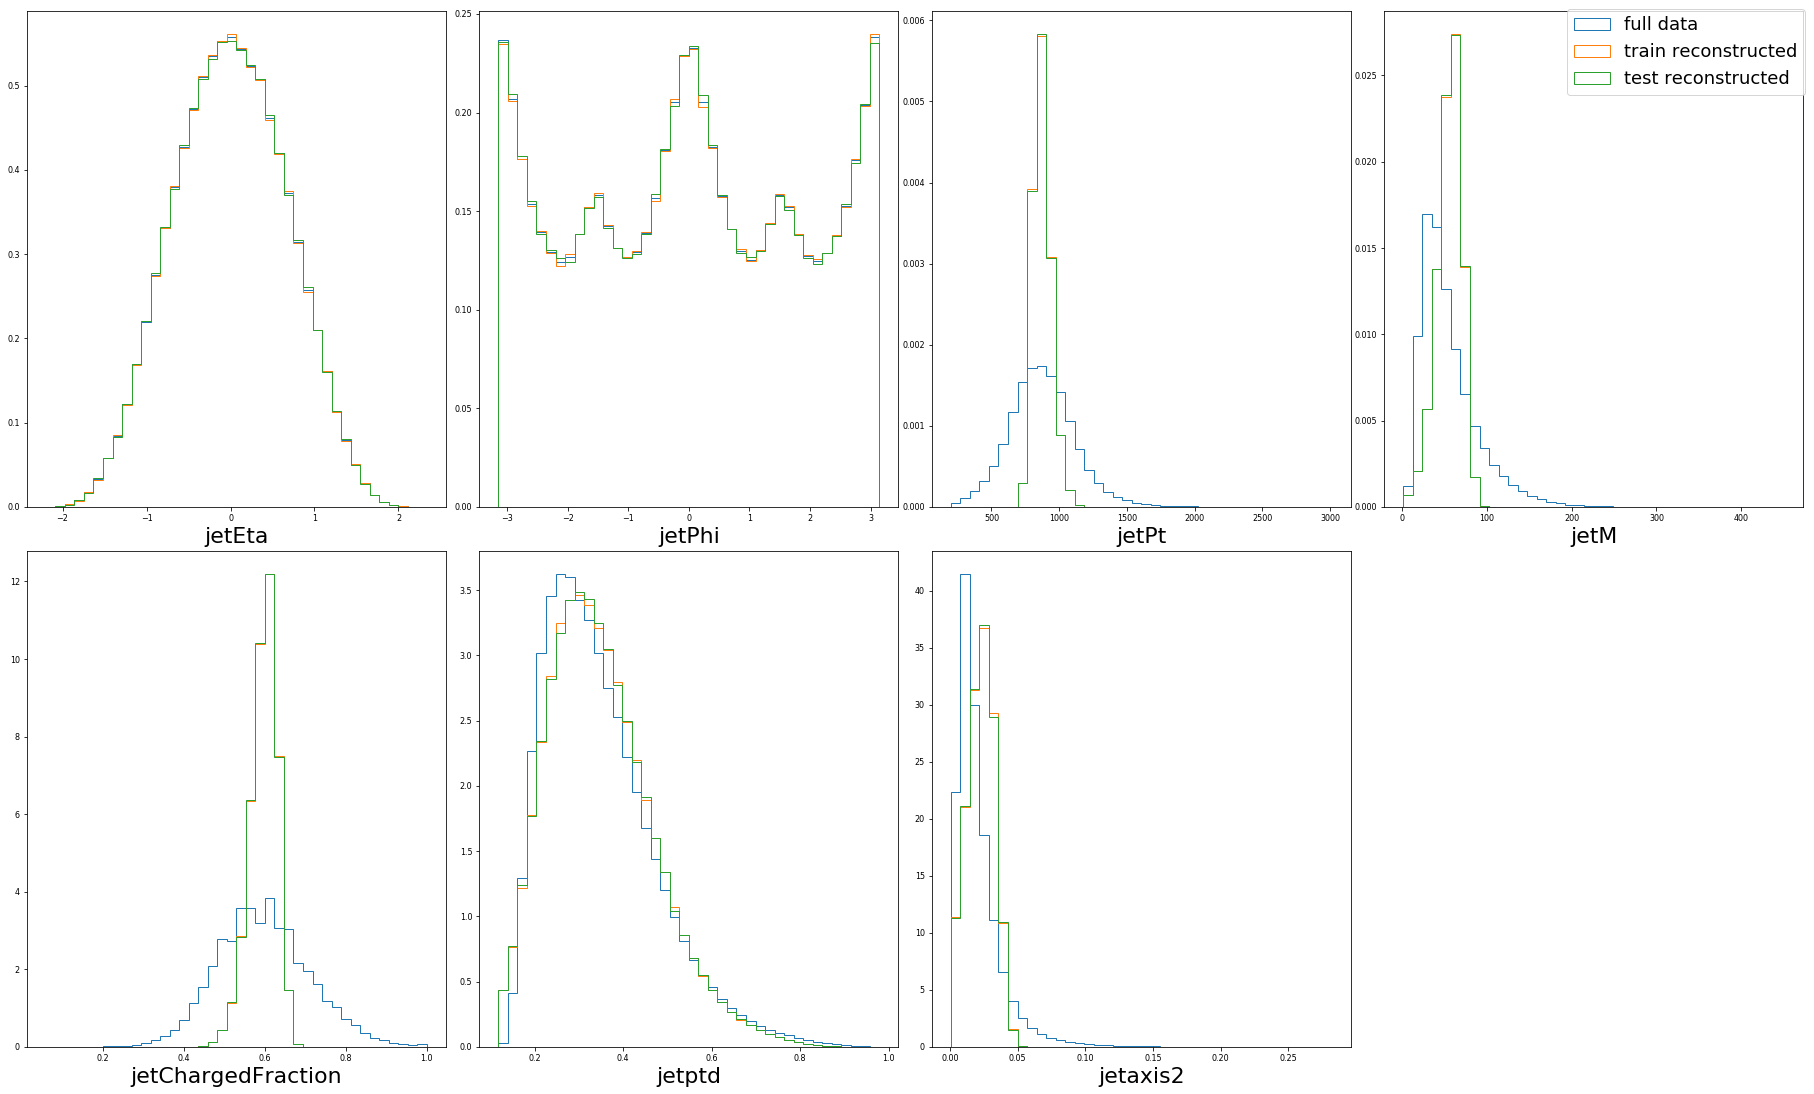

In [28]:
train_reconstructed_norm = data_table(autoencoder.predict(train_norm.data), headers=train_norm.headers)
test_reconstructed_norm = data_table(autoencoder.predict(test_norm.data), headers=test_norm.headers)

train_reconstructed = data.inorm(train_reconstructed_norm)
test_reconstructed = data.inorm(test_reconstructed_norm)


train_reconstructed.name = "train reconstructed"
test_reconstructed.name = "test reconstructed"

# train.plot([train_reconstructed], bins = 30, alpha=1.0)
# test.plot([test_reconstructed], bins=30, alpha=1.0)
data.plot(
    [train_reconstructed, test_reconstructed],
    normed=1, bins=40, alpha=1.0, figloc="upper right",
    figsize=(25,15), fontsize=22
)

In [26]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    data_table(encoder.predict(train_norm.data), name="train_reps"),
    data_table(encoder.predict(test_norm.data), name="test_reps")
)

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


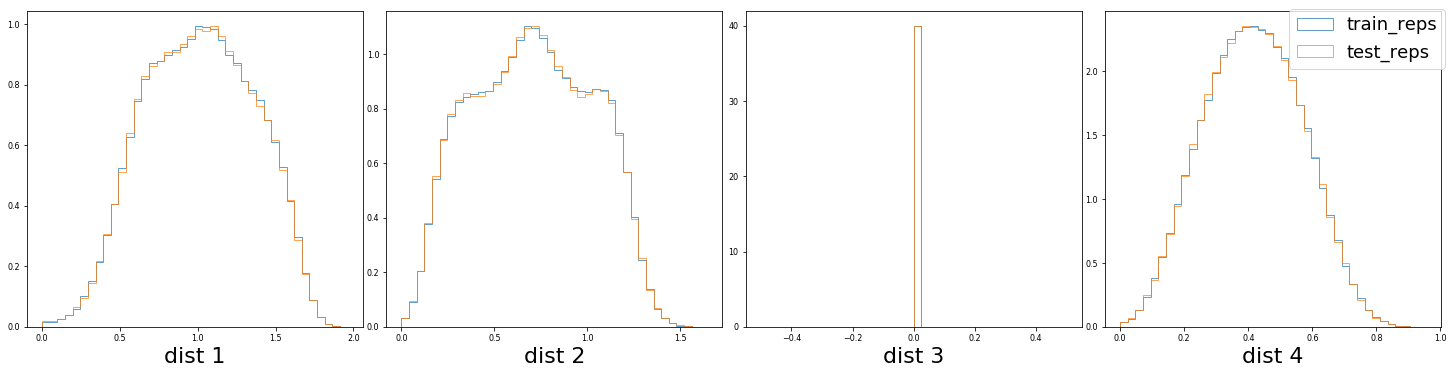

In [29]:
train_reps.plot([test_reps], cols=4, figsize=(20,5), fontsize=22, normed=1, bins=40)

### 5. reproduce
These results are saved for later and can be easily accessed with the h5 files saved, or using the training_skeleton instance:

In [20]:
if "trainer" in locals():
    del trainer

tnew = training_skeleton("data/training_runs/16hlf/shallow_5")

train_shell :: locking file '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/16hlf/shallow_5.h5'
h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'shallow_5.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'shallow_5.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'shallow_5.h5'
h5_elt 'acc' :: loading dataset 'metric_names/acc' from file 'shallow_5.h5'
h5_elt 'loss' :: loading dataset 'metric_names/loss' from file 'shallow_5.h5'
h5_elt 'val_acc' :: loading dataset 'metric_names/val_acc' from file 'shallow_5.h5'
h5_elt 'val_loss' :: loading dataset 'metric_names/val_loss' from file 'shallow_5.h5'
